# Introduction

### Problem Description

In this presentation, performance of LSTM (Long Short-Term Memory neural network) in a specific task is compared with that of MLP (Multi-Layer Perceptron). However, MLP is trained on a data matrix where features are derived based on varying number of previous steps. Such feature engineering mimics ability to remember past information for an arbitrary number of time steps.  

Generally speaking, the task under consideration is forecasting with horizon that is bigger than one step. In other words, models are trained to predict future values several steps ahead simultaneously, without passing predictions for previous future steps as ground truth. It is assumed that models should be trained to recognize temporal patterns in a sequence of observations, and prediction of future values based on external variables is beyond the scope of the presentation.

Time series that are used here is a real-world series with hourly frequency and strong intraday seasonality. Because aim of the presentation is to compare performance that is due to sequence modelling aspects of forecasting, nature of the series is not relevant here. Of course, involvement of domain-related features and appropriate external data can result in better accuracy of forecasting.

### Software Requirements

Besides packages that are quite popular in scientific computing, this notebook requires `tensorflow` of version 1.0 or newer. Please look at the [official installation guide](https://www.tensorflow.org/install/) if you need to install or update it.

# General Preparations

### Import Statements

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  # Imported just in order to make graphs prettier.

from sklearn.metrics import r2_score

import tensorflow as tf

### Data Extraction and Exploratory Analysis

In [2]:
ser = pd.read_csv('series_with_seasonality.csv', sep='\t')['value']
ser.head()

0    1.7024
1    0.3600
2    0.0000
3    0.0000
4    0.2848
Name: value, dtype: float64

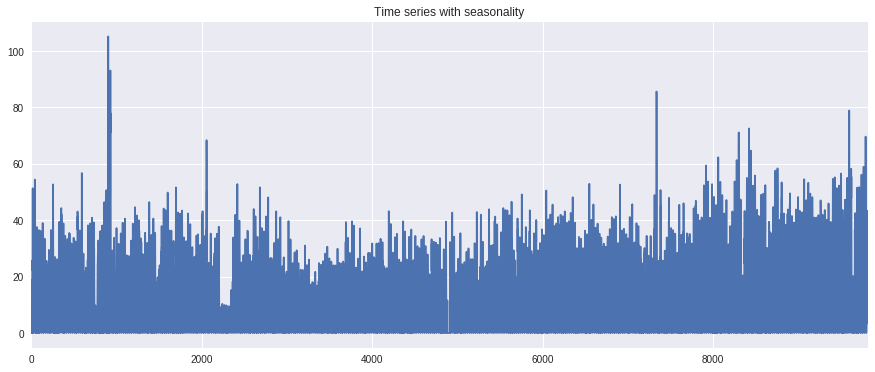

In [3]:
_ = ser.plot(figsize=(15, 6), title='Time series with seasonality')

It is hard to study the series behavior from the above graph, so look at a small pieces of it.

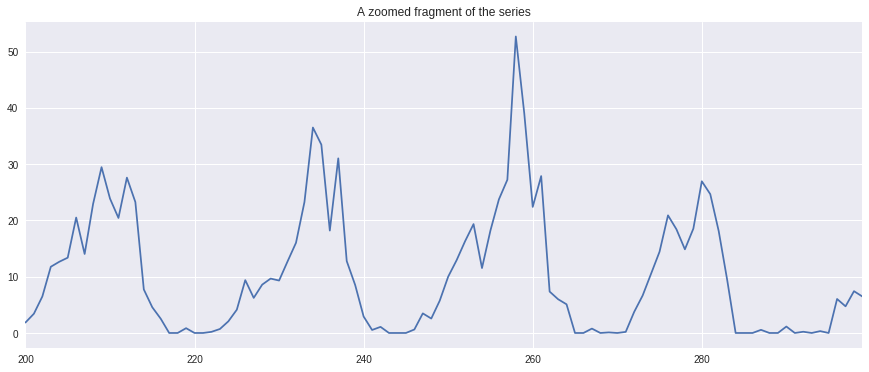

In [4]:
_ = ser[200:300].plot(figsize=(15, 6), title='A zoomed fragment of the series')

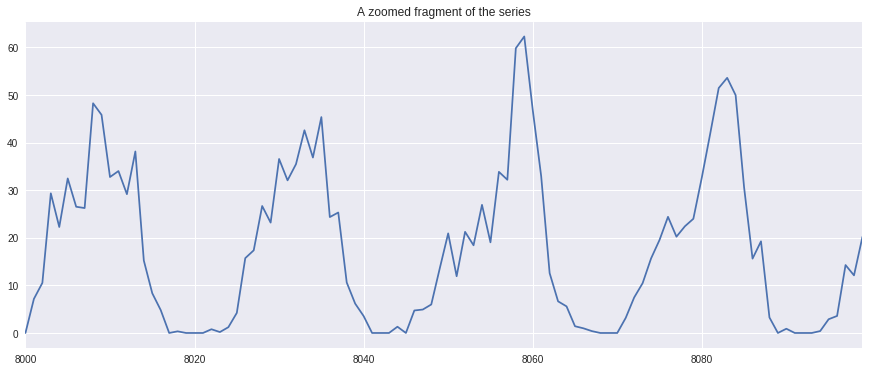

In [5]:
_ = ser[8000:8100].plot(figsize=(15, 6), title='A zoomed fragment of the series')

In [6]:
ser.describe()

count    9817.000000
mean       12.375714
std        12.806379
min         0.000000
25%         0.860800
50%         9.028800
75%        20.532800
max       105.168000
Name: value, dtype: float64

### Baseline model

What forecast quality can be achieved by a simple baseline model such as, say, moving average of a specific window size?

Below MA(24) model is chosen, because 24 is period of seasonality of the series. One can try to use other window sizes — the higher they are, the more slowly predictions made for a long horizon converge to a constant.

In [7]:
window_size = 24
horizon = 100

Split data to a "train" set (actually, moving average has no fitting) and a hold-out test set. 

In [8]:
train_ratio = 0.75
train_test_frontier = int(round(train_ratio * len(ser.index), 0))

-0.10188688141676283

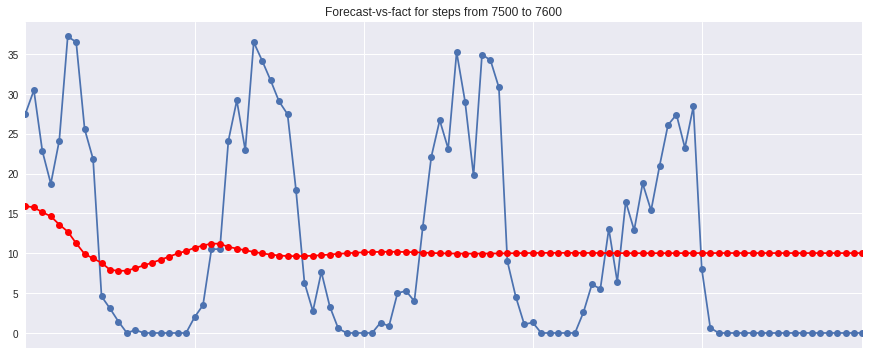

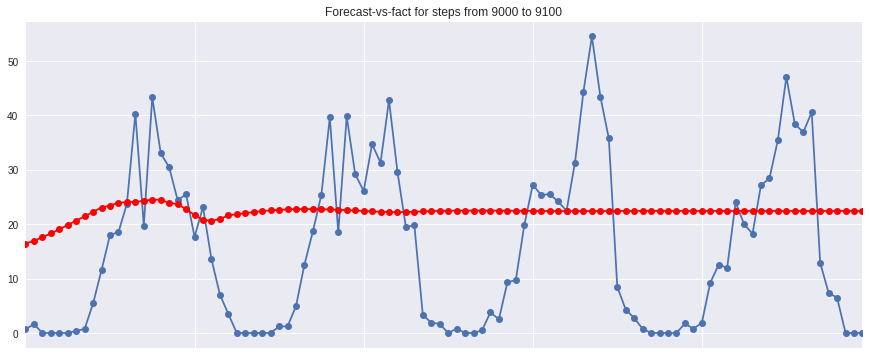

In [9]:
scores = []
for i in range(train_test_frontier, len(ser.index) - horizon):
    y_true = ser.iloc[i:(i + horizon)]
    y_hat = ser.iloc[(i - window_size):i].tolist()
    for j in range(horizon):
        y_hat.append(sum(y_hat[-window_size:]) / window_size)

    y_hat = y_hat[window_size:]
    score = r2_score(y_true, y_hat)
    scores.append(score)
    
    if i % 1500 == 0:
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(i, i + horizon))
        ax.set_xticklabels([])
        
        y_true.plot(ax=ax, marker='o')
        pd.Series(y_hat, index=y_true.index).plot(ax=ax, c='red', marker='o')

sum(scores) / len(scores)

Of course, negative value of $R^2$ score is not a bug. As it can be seen, MA(24) predictions converge quite rapidly to a constant. If this constant is equal to mean of the corresponding slice from the true series, $R^2$ score is 0, because the model does not explain any variation around the mean. However, any constant that is not equal to the true mean, is worse than the true mean from MSE minimization point of view, and so $R^2$ coefficient of determination is even lower than 0, i.e. it is negative.

# Template of Forecasting

In [10]:
class AbstractRunner(object):
    """
    Combines and structurizes all utilities
    that evaluate neural networks' performances
    in the task of forecasting `horizon` steps
    ahead with `n_lags` previous values
    and a current value as features
    (also other features may be involved).
    """
    
    def __init__(self, horizon, n_lags):
        """
        @type horizon: int
        @type n_lags: int
        """
        self.horizon = horizon
        self.n_lags = n_lags
        
        self.sess = None
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Define placeholders.
            self.inputs = tf.placeholder(tf.float32,
                                         shape=(None, None, self.n_lags + 1),
                                         name='inputs')
            self.targets = tf.placeholder(tf.float32,
                                          shape=(None, None, self.horizon),
                                          name='targets')
            self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
            
    def _train(self, train_ser, batch_size, n_epochs, learn_rate, ckpt_path):
        """
        A virtual method.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")

    def _test(self, test_ser):
        """
        A virtual method.
        
        @type test_ser: pandas.Series
        @rtype: float
        """
        raise NotImplemented("Class `AbstractRunner` must not have any instances.")
        
    def _plot(self, true_series, forecasted_series, batch_cnt):
        """
        Visualizes `forecasted_series` against
        `true_series` for a time interval that
        corresponds to `batch_cnt`.
        
        @type true_series: numpy.ndarray
        @type forecasted_series: numpy.ndarray
        @type batch_cnt: int
        @rtype: NoneType
        """
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        start_step = train_test_frontier + batch_cnt  # TODO: capitalize `train_test_frontier`?
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(
            start_step, start_step + self.horizon))
        ax.set_xticklabels([])

        pd.Series(true_series).plot(ax=ax, marker='o')
        pd.Series(forecasted_series).plot(ax=ax, c='red', marker='o')
        
    def run(self, train_ser, test_ser, batch_size, n_epochs, learn_rate,
            ckpt_path=None):
        """
        Trains a model with a specified
        hyperparameters on `train_ser` and
        then evaluates its performance on
        `test_ser`.
        If `ckpt_path` is passed, the trained
        model is serialized as checkpoint
        files.
        
        @type train_ser: pandas.Series
        @type test_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @rtype: float
        """
        with tf.Session(graph=self.graph) as self.sess:
            self.sess.run(tf.global_variables_initializer())
            self._train(train_ser, batch_size, n_epochs, learn_rate, ckpt_path)
            score = self._test(test_ser)
        return score

# Forecasting with LSTM

### Functions and Classes

In [11]:
def build_rnn(inputs, n_outputs, rnn_width, rnn_depth):
    """
    Defines architecture of an RNN.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type rnn_width: int
    @type rnn_depth: int
    @rtype: tuple(tensorflow.Tensor)
    """
    basic_cell = tf.contrib.rnn.BasicLSTMCell(rnn_width)
    multi_cell = tf.contrib.rnn.MultiRNNCell([basic_cell for _ in range(rnn_depth)])
    
    batch_size = tf.shape(inputs)[0]
    initial_state = tf.identity(multi_cell.zero_state(batch_size, tf.float32),
                                name='initial_state')
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(multi_cell, inputs, dtype=tf.float32)
    final_state = tf.identity(final_state, name='final_state')
    
    preds = tf.contrib.layers.fully_connected(lstm_outputs, n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds, initial_state, final_state

In [12]:
def get_batches_for_lstm(ser, batch_size, horizon, n_lags, n_time_steps=1):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @type n_time_steps: int
    @rtype: list(tuple(numpy.ndarray))
    """
    df = ser.to_frame(name='curr_value')
    for i in range(1, n_lags + 1):
        df['lag_{}'.format(i)] = df['curr_value'].shift(i)
    for i in range(1, horizon + 1):
        df['ahead_{}'.format(i)] = df['curr_value'].shift(-i)
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[n_lags:(n_batches*batch_size + n_lags), :]

    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_time_steps, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, n_time_steps, horizon))
    return list(zip(x_array, y_array))

In [13]:
class RunnerOfLSTM(AbstractRunner):
    """
    Combines and structurizes all utilities
    that evaluate LSTM performance in
    the task of forecasting `horizon` steps
    ahead with `n_lags` previous values
    and a current value as features.
    """
    
    def __init__(self, horizon, n_lags, rnn_width, rnn_depth):
        """
        @type horizon: int
        @type n_lags: int
        @type rnn_width: int
        @type rnn_depth: int
        """
        super().__init__(horizon, n_lags)
        self.rnn_width = rnn_width
        self.rnn_depth = rnn_depth
        
        self.state = None
        
        with self.graph.as_default():
            # Build a neural network.
            self.preds, self.initial_state, self.final_state = \
                build_rnn(self.inputs, self.horizon, self.rnn_width, self.rnn_depth)
                
            # Set an optimizational problem.
            self.cost = tf.losses.mean_squared_error(self.targets, self.preds)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)

            # Clip gradients in order to improve convergence.
            gradients = optimizer.compute_gradients(self.cost)
            capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var)
                                for grad, var in gradients]
            self.train_optim = optimizer.apply_gradients(capped_gradients)

    def _train(self, train_ser, batch_size, n_epochs, learn_rate, ckpt_path):
        """
        Trains LSTM and informs about training.
        Also can save trained model and
        its last state if `ckpt_path` is set.
        
        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        batches = get_batches_for_lstm(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            # Reset state, because batches are started from the beginning of the series.
            state = self.sess.run(self.initial_state, {self.inputs: batches[0][0]})

            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.initial_state: state,
                             self.learning_rate: learn_rate}
                y_hat, state, train_loss, _ = self.sess.run([self.preds,
                                                             self.final_state,
                                                             self.cost,
                                                             self.train_optim],
                                                            feed_dict)
            if epoch_cnt % 10 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        self.state = state
        if ckpt_path is not None:
            np.save(ckpt_path + '.state', self.state)
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.
        
        @type test_ser: pandas.Series
        @rtype: float
        """
        scores = []
        batches = get_batches_for_lstm(test_ser, 1, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            y_hat, state = self.sess.run([self.preds, self.final_state],
                                         {self.inputs: x,
                                          self.initial_state: self.state})
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0][0], y_hat[0][0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                self._plot(y[0][0], y_hat[0][0], batch_cnt)
        
        return sum(scores) / len(scores)

### Application

Here a massive LSTM is trained. To achieve test set $R^2$ coefficient of determination over 0.6, it is enough to have 24 lags and 100 epochs of training a network with hidden layers' width equal to 32.

In [14]:
# Sample parameters.
horizon = 100
n_lags = 168

# Hyperparameters of architecture.
rnn_width = 64
rnn_depth = 2

# Hyperparameters of training.
batch_size = 32
n_epochs = 300
learn_rate = 0.001

Epoch   0:    train_loss = 201.508
Epoch  10:    train_loss = 189.617
Epoch  20:    train_loss = 189.328
Epoch  30:    train_loss = 189.137
Epoch  40:    train_loss = 189.280
Epoch  50:    train_loss = 189.326
Epoch  60:    train_loss = 189.395
Epoch  70:    train_loss = 189.571
Epoch  80:    train_loss = 189.475
Epoch  90:    train_loss = 189.236
Epoch 100:    train_loss = 189.344
Epoch 110:    train_loss = 189.188
Epoch 120:    train_loss = 189.185
Epoch 130:    train_loss = 189.239
Epoch 140:    train_loss = 131.916
Epoch 150:    train_loss = 105.188
Epoch 160:    train_loss = 98.397
Epoch 170:    train_loss = 88.766
Epoch 180:    train_loss = 85.284
Epoch 190:    train_loss = 86.191
Epoch 200:    train_loss = 84.653
Epoch 210:    train_loss = 84.119
Epoch 220:    train_loss = 83.989
Epoch 230:    train_loss = 84.616
Epoch 240:    train_loss = 85.456
Epoch 250:    train_loss = 85.214
Epoch 260:    train_loss = 82.872
Epoch 270:    train_loss = 83.770
Epoch 280:    train_loss = 84.20

0.62582629609814355

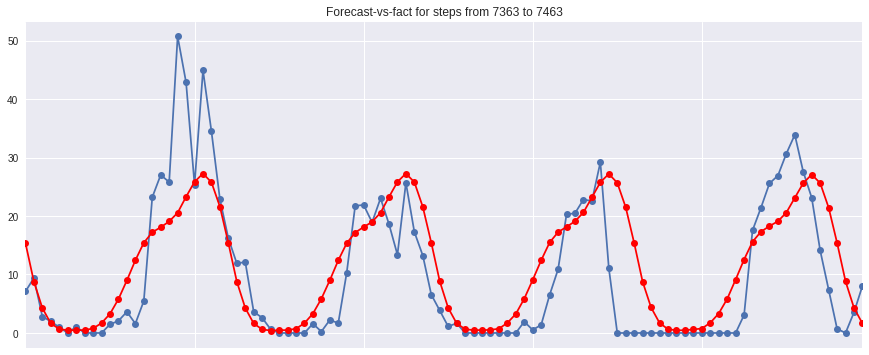

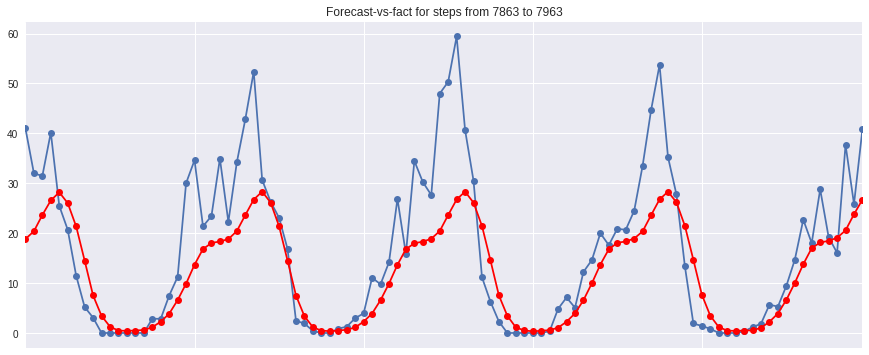

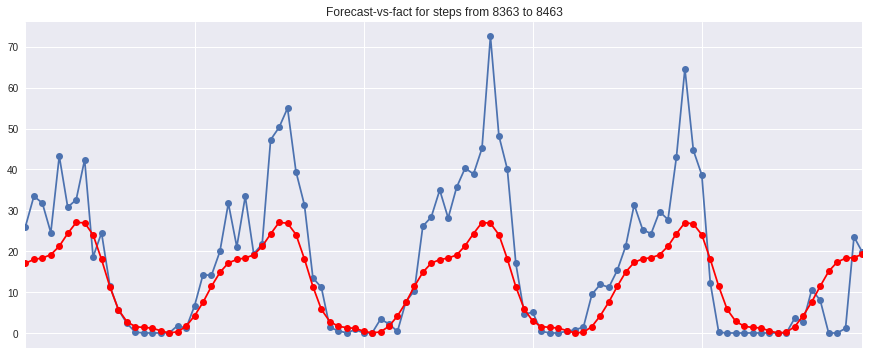

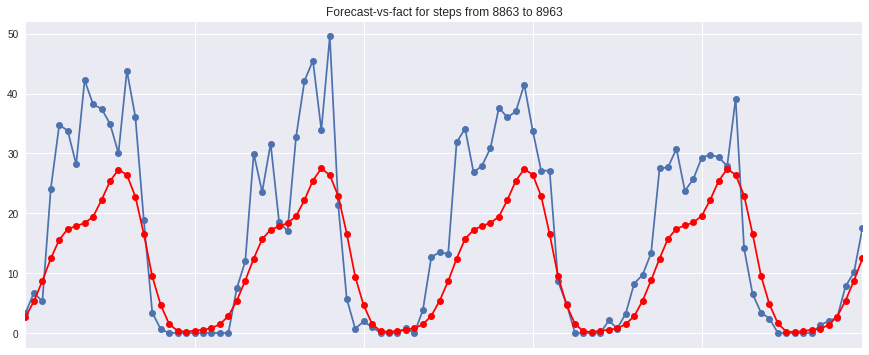

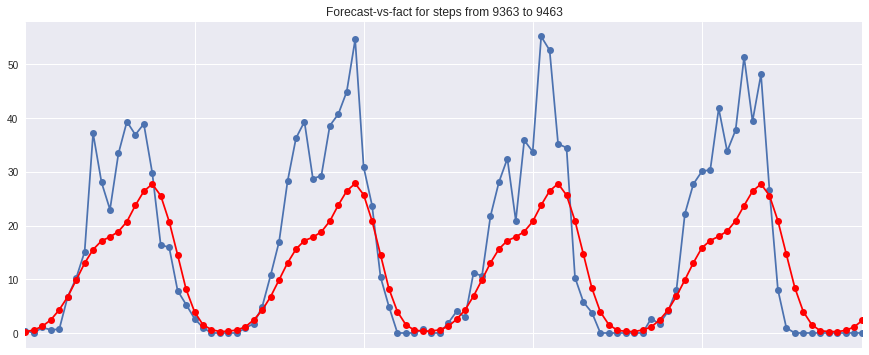

In [15]:
lstm_runner = RunnerOfLSTM(horizon, n_lags, rnn_width, rnn_depth)
score = lstm_runner.run(ser[:train_test_frontier],  # Not `ser[:train_test_frontier + horizon]`.
                        ser[train_test_frontier - n_lags:],  # To have lag features.
                        batch_size, n_epochs, learn_rate,
                        ckpt_path='./trained_models/lstm.ckpt')
score

Results are quite decent — $R^2$ is about two-thirds. Graphs evidence that LSTM has successfully learnt intraday seasonality pattern.

# Forecasting with MLP

### Functions and classes

In [16]:
def build_mlp(inputs, n_outputs, hidden_layers_widths):
    """
    Defines architecture of an MLP.
    
    @type inputs: tensorflow.Tensor
    @type n_outputs: int
    @type hidden_layers_widths: list(int)
    @rtype: tensorflow.Tensor
    """
    layers = [inputs]
    for i in range(len(hidden_layers_widths)):
        layers.append(tf.contrib.layers.fully_connected(layers[-1],
                                                        hidden_layers_widths[i],
                                                        activation_fn=None))
    preds = tf.contrib.layers.fully_connected(layers[-1],
                                              n_outputs,
                                              activation_fn=None)
    preds = tf.identity(preds, name='predictions')
    return preds

In [17]:
def get_batches_for_mlp(ser, batch_size, horizon, n_lags, n_time_steps=1):
    """
    Converts time series to batches
    represented as data matrices.
    
    @type ser: pandas.Series
    @type batch_size: int
    @type horizon: int
    @type n_lags: int
    @type n_time_steps: int
    @rtype: list(tuple(numpy.ndarray))
    """
    # TODO: Engineer features described in the problem setup.
    df = ser.to_frame(name='curr_value')
    for i in range(1, n_lags + 1):
        df['lag_{}'.format(i)] = df['curr_value'].shift(i)
    for i in range(1, horizon + 1):
        df['ahead_{}'.format(i)] = df['curr_value'].shift(-i)
    n_batches = (len(ser) - horizon - n_lags) // batch_size
    df = df.iloc[n_lags:(n_batches*batch_size + n_lags), :]

    x_array = df.iloc[:, :-horizon].values.reshape((n_batches, -1, n_time_steps, n_lags + 1))
    y_array = df.iloc[:, -horizon:].values.reshape((n_batches, -1, n_time_steps, horizon))
    return list(zip(x_array, y_array))

In [18]:
class RunnerOfMLP(AbstractRunner):
    """
    Combines and structurizes all utilities
    that evaluate MLP performance in
    the task of forecasting `horizon` steps
    ahead with `n_lags` previous values,
    a current value, and some aggregates
    as features.
    """

    def __init__(self, horizon, n_lags, hidden_layers_widths):
        """
        @type horizon: int
        @type n_lags: int
        @type hidden_layers_width: int
        """
        super().__init__(horizon, n_lags)
        self.hidden_layers_widths = hidden_layers_widths
        
        with self.graph.as_default():
            # Build a neural network.
            self.preds = build_mlp(self.inputs, self.horizon, self.hidden_layers_widths)
   
            # Set an optimizational problem.
            self.cost = tf.losses.mean_squared_error(self.targets, self.preds)
            optimizer = tf.train.AdamOptimizer(self.learning_rate)

            # Clip gradients in order to improve convergence.
            gradients = optimizer.compute_gradients(self.cost)
            capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var)
                                for grad, var in gradients]
            self.train_optim = optimizer.apply_gradients(capped_gradients)

    def _train(self, train_ser, batch_size, n_epochs, learn_rate, ckpt_path):
        """
        Trains MLP and informs about training.
        Also can save trained model
        if `ckpt_path` is set.

        @type train_ser: pandas.Series
        @type batch_size: int
        @type n_epochs: int
        @type learn_rate: float
        @type ckpt_path: str
        @rtype: NoneType
        """
        batches = get_batches_for_mlp(train_ser, batch_size, self.horizon, self.n_lags)

        for epoch_cnt in range(n_epochs):
            for batch_cnt, (x, y) in enumerate(batches):
                feed_dict = {self.inputs: x,
                             self.targets: y,
                             self.learning_rate: learn_rate}
                y_hat, train_loss, _ = self.sess.run([self.preds,
                                                      self.cost,
                                                      self.train_optim],
                                                     feed_dict)
            if epoch_cnt % 5 == 0:
                print('Epoch {:>3}:    train_loss = {:.3f}'.format(epoch_cnt, train_loss))
                        
        if ckpt_path is not None:
            saver = tf.train.Saver()
            saver.save(self.sess, ckpt_path)

    def _test(self, test_ser):
        """
        Reports performance on hold-out test set
        as coefficient of determination.
        Also visualizes some predictions against
        the corresponding actual values.

        @type test_ser: pandas.Series
        @rtype: float
        """
        scores = []
        batches = get_batches_for_mlp(test_ser, 1, self.horizon, self.n_lags)
        for batch_cnt, (x, y) in enumerate(batches):
            y_hat = self.sess.run(self.preds, {self.inputs: x})
            y_hat[y_hat < 0] = 0  # Obvious improvement.
            curr_score = r2_score(y[0][0], y_hat[0][0])
            scores.append(curr_score)

            if batch_cnt % 500 == 0:
                self._plot(y[0][0], y_hat[0][0], batch_cnt)

        return sum(scores) / len(scores)

### Application

In [19]:
# Sample parameters.
horizon = 100
n_lags = 168

# Hyperparameters of architecture.
hidden_layers_widths = [8]

# Hyperparameters of training.
batch_size = 32
n_epochs = 30
learn_rate = 0.001

Epoch   0:    train_loss = 99.501
Epoch   5:    train_loss = 90.852
Epoch  10:    train_loss = 87.798
Epoch  15:    train_loss = 87.317
Epoch  20:    train_loss = 88.482
Epoch  25:    train_loss = 89.461


0.73751195084255872

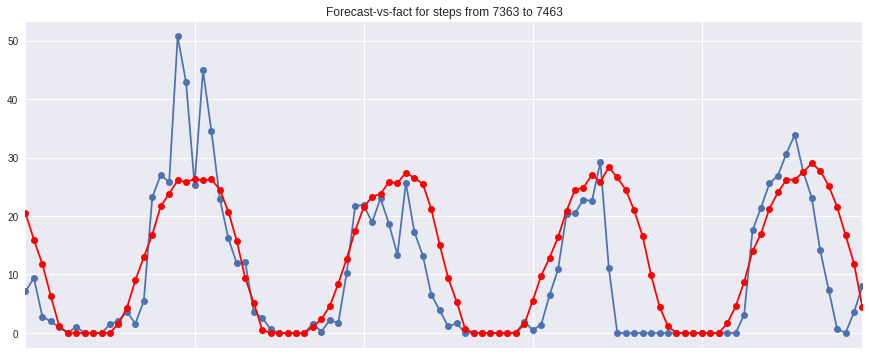

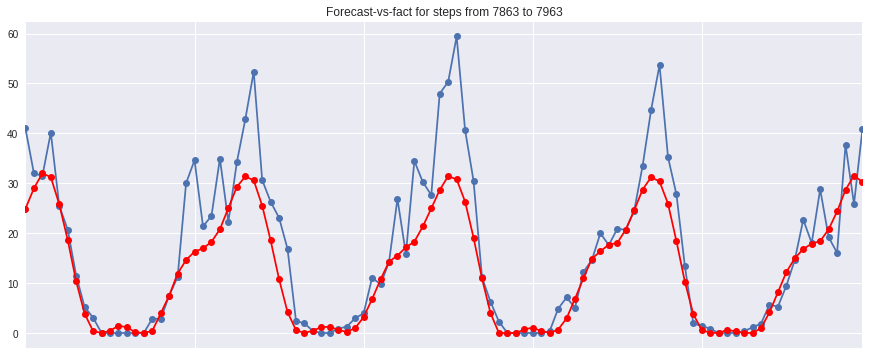

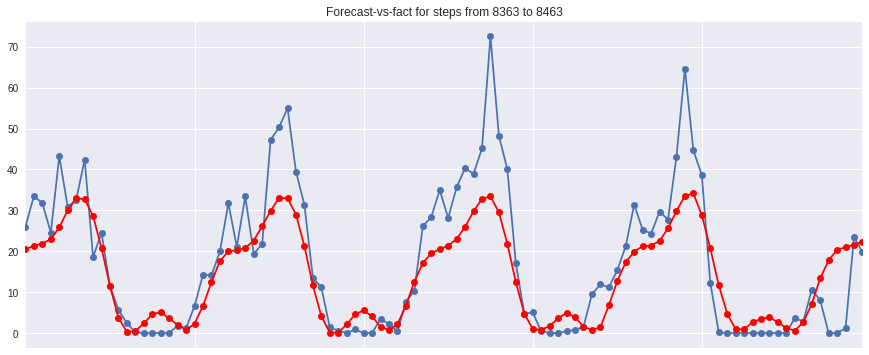

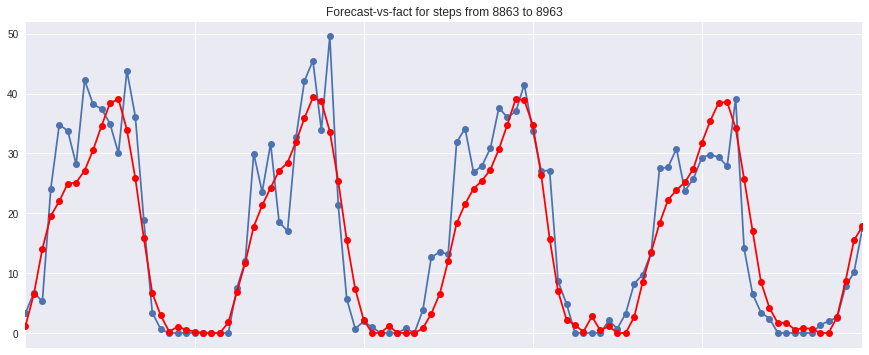

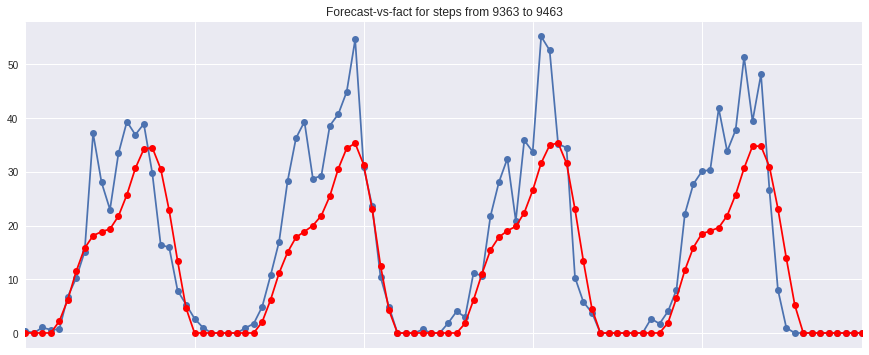

In [20]:
mlp_runner = RunnerOfMLP(horizon, n_lags, hidden_layers_widths)
score = mlp_runner.run(ser[:train_test_frontier],  # Not `ser[:train_test_frontier + horizon]`.
                       ser[train_test_frontier - n_lags:],  # To have lag features.
                       batch_size, n_epochs, learn_rate,
                       ckpt_path='./trained_models/mlp.ckpt')
score

The score is significantly higher than that of LSTM and training goes much faster.

# Conclusion

To be continued.